In [ ]:

%matplotlib inline
import numpy as np
import torch
import torch.optim as optim

torch.set_printoptions(edgeitems=2, linewidth=75)
t_c = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c).unsqueeze(1) # <1>
t_u = torch.tensor(t_u).unsqueeze(1) # <1>

t_u.shape
n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples)

shuffled_indices = torch.randperm(n_samples)

train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

train_indices, val_indices

t_u_train = t_u[train_indices]
t_c_train = t_c[train_indices]

t_u_val = t_u[val_indices]
t_c_val = t_c[val_indices]

t_un_train = 0.1 * t_u_train
t_un_val = 0.1 * t_u_val


PyTorch는 torch.nn이라 불리는 module을 가지고 있다. 

building blocks은 module이라 불린다.

nn.Module의 subclass에는 nn.Linear가 있다. 이는 affine transformation을 하게 해준다.

### 6.2.1 Using \_\_call\_\_ rather than forward

모든 PyTorch의 nn.module의 subclass는 \_\_call\_\_ method가 존재한다.

In [ ]:
import torch.nn as nn

linear_model = nn.Linear(1,1)
linear_model(t_un_val)


tensor([[-3.1078],
        [-1.5641]], grad_fn=<AddmmBackward>)

또한 내부에 있는 forward method는 forward computation을 한다.

하지만 이는 user code level에서는 하지 않는것이 바람직 하다. 

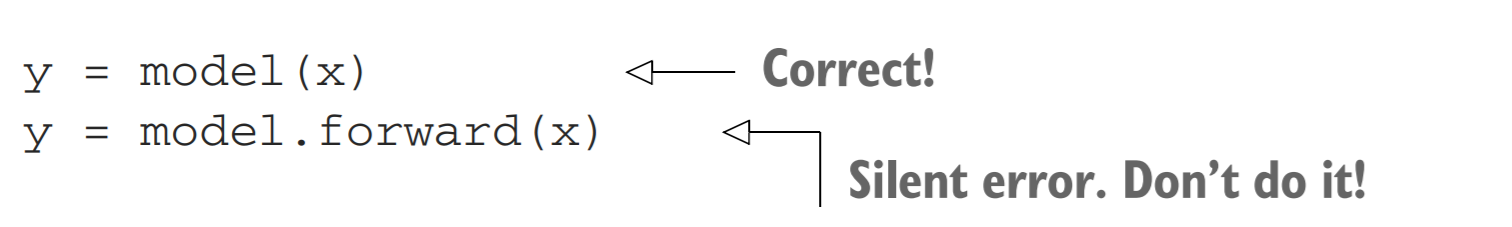

Module.\_\_call\_\_의 코드는 다음과 같다.

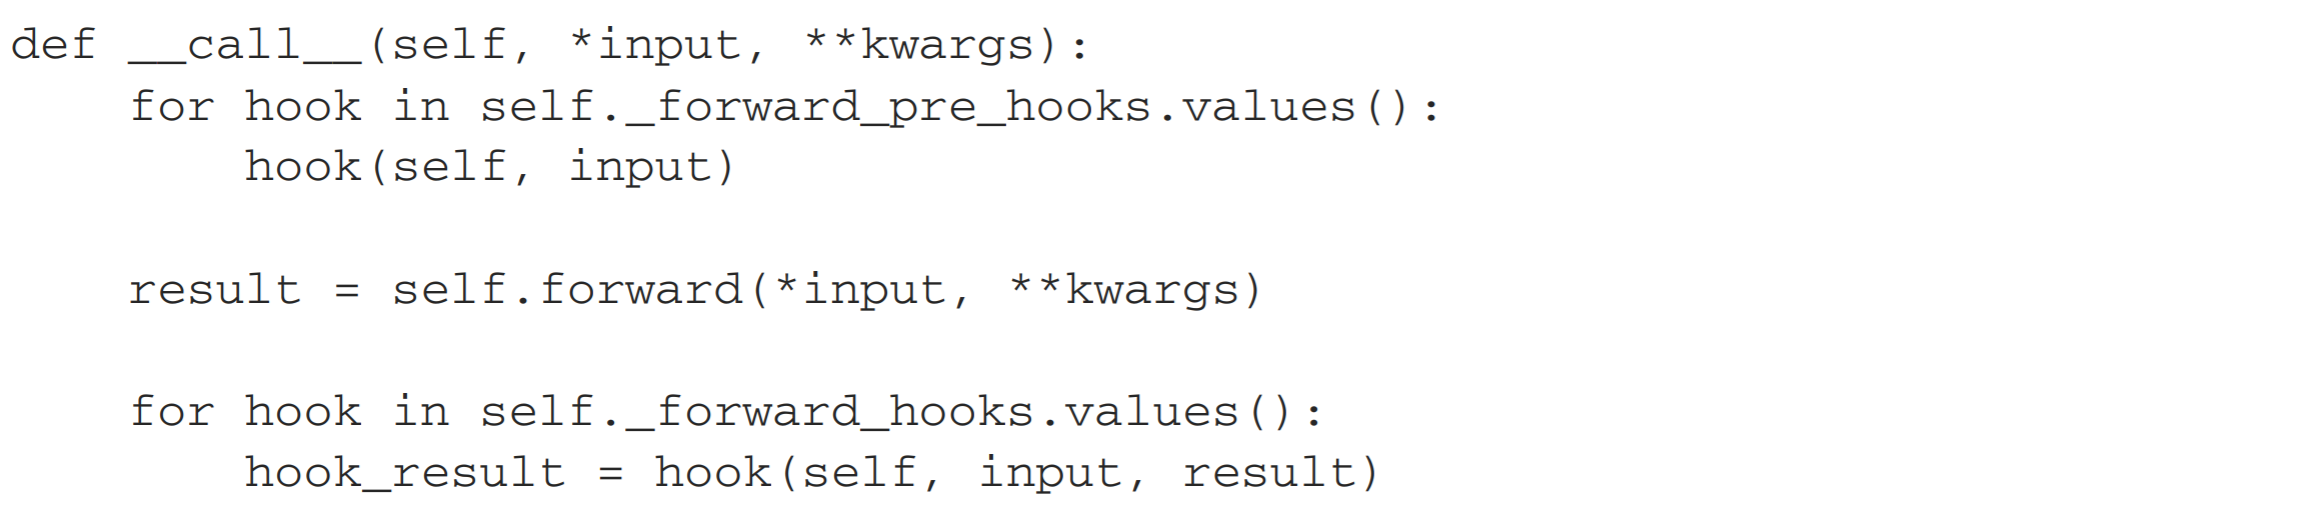

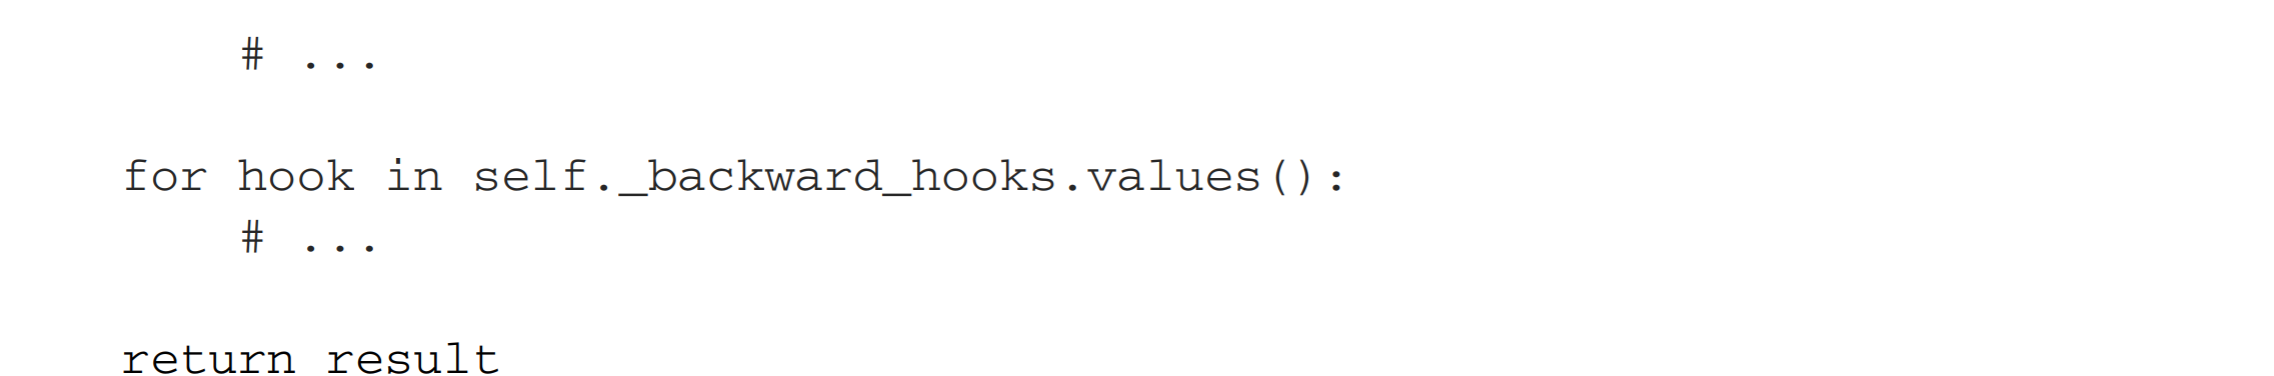

### 6.2.2 Returning to the linear model

nn.Linear는 3개의 인자를 받는다. 

input feature의 갯수, output feature의 갯수, linear model이 bias를 가지는 지의 여부 (defeault = True)



In [ ]:
linear_model.weight

Parameter containing:
tensor([[-0.3313]], requires_grad=True)

In [ ]:
linear_model.bias

Parameter containing:
tensor([-0.8419], requires_grad=True)

In [ ]:
linear_model(torch.ones(1))

tensor([-1.1732], grad_fn=<AddBackward0>)

In [ ]:
-0.3313*1+(-0.8419)

-1.1732

nn은 여러개의 input인 batch에 대해서도 잘 동작한다.

In [ ]:
linear_model(torch.ones(10,1))

tensor([[-1.1732],
        [-1.1732],
        [-1.1732],
        [-1.1732],
        [-1.1732],
        [-1.1732],
        [-1.1732],
        [-1.1732],
        [-1.1732],
        [-1.1732]], grad_fn=<AddmmBackward>)

**Optimizing batches**



In [ ]:
t_c = [0.5, 14.0, 15.0, 28.0, 11.0, 8.0, 3.0, -4.0, 6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c).unsqueeze(1)
t_u = torch.tensor(t_u).unsqueeze(1)
t_u.shape

torch.Size([11, 1])

기존의 손으로 만든 모델 대신 nn.Linear를 사용하고 optimizer를 추가하자.


In [ ]:
linear_model = nn.Linear(1, 1)
optimizer = optim.SGD(
linear_model.parameters(),
lr=1e-2)

In [ ]:
linear_model.parameters()

<generator object Module.parameters at 0x7ffb5dd9ce50>

In [ ]:
list(linear_model.parameters())

[Parameter containing:
 tensor([[0.7788]], requires_grad=True), Parameter containing:
 tensor([0.4056], requires_grad=True)]

Training Loop는 다음과 같다.

In [ ]:
def training_loop(n_epochs, optimizer, model, loss_fn, t_u_train, t_u_val,t_c_train, t_c_val):
    for epoch in range(1, n_epochs + 1):
        t_p_train = model(t_u_train)
        loss_train = loss_fn(t_p_train, t_c_train)
        t_p_val = model(t_u_val)
        loss_val = loss_fn(t_p_val, t_c_val)
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()
        if epoch == 1 or epoch % 1000 == 0:
            print(f"Epoch {epoch}, Training loss {loss_train.item():.4f},"        f" Validation loss {loss_val.item():.4f}")

In [ ]:
training_loop(
n_epochs = 3000,
optimizer = optimizer,
model = linear_model,
loss_fn = nn.MSELoss(),
t_u_train = t_un_train,
t_u_val = t_un_val,
t_c_train = t_c_train,
t_c_val = t_c_val)
print()
print(linear_model.weight)
print(linear_model.bias)

Epoch 1, Training loss 84.7137, Validation loss 135.1687
Epoch 1000, Training loss 4.9805, Validation loss 5.0543
Epoch 2000, Training loss 3.0454, Validation loss 3.0581
Epoch 3000, Training loss 2.8585, Validation loss 3.8883

Parameter containing:
tensor([[5.4276]], requires_grad=True)
Parameter containing:
tensor([-17.9452], requires_grad=True)


이로써 하나의 Neuron을 학습하는 방식을 찾을 수 있었다.

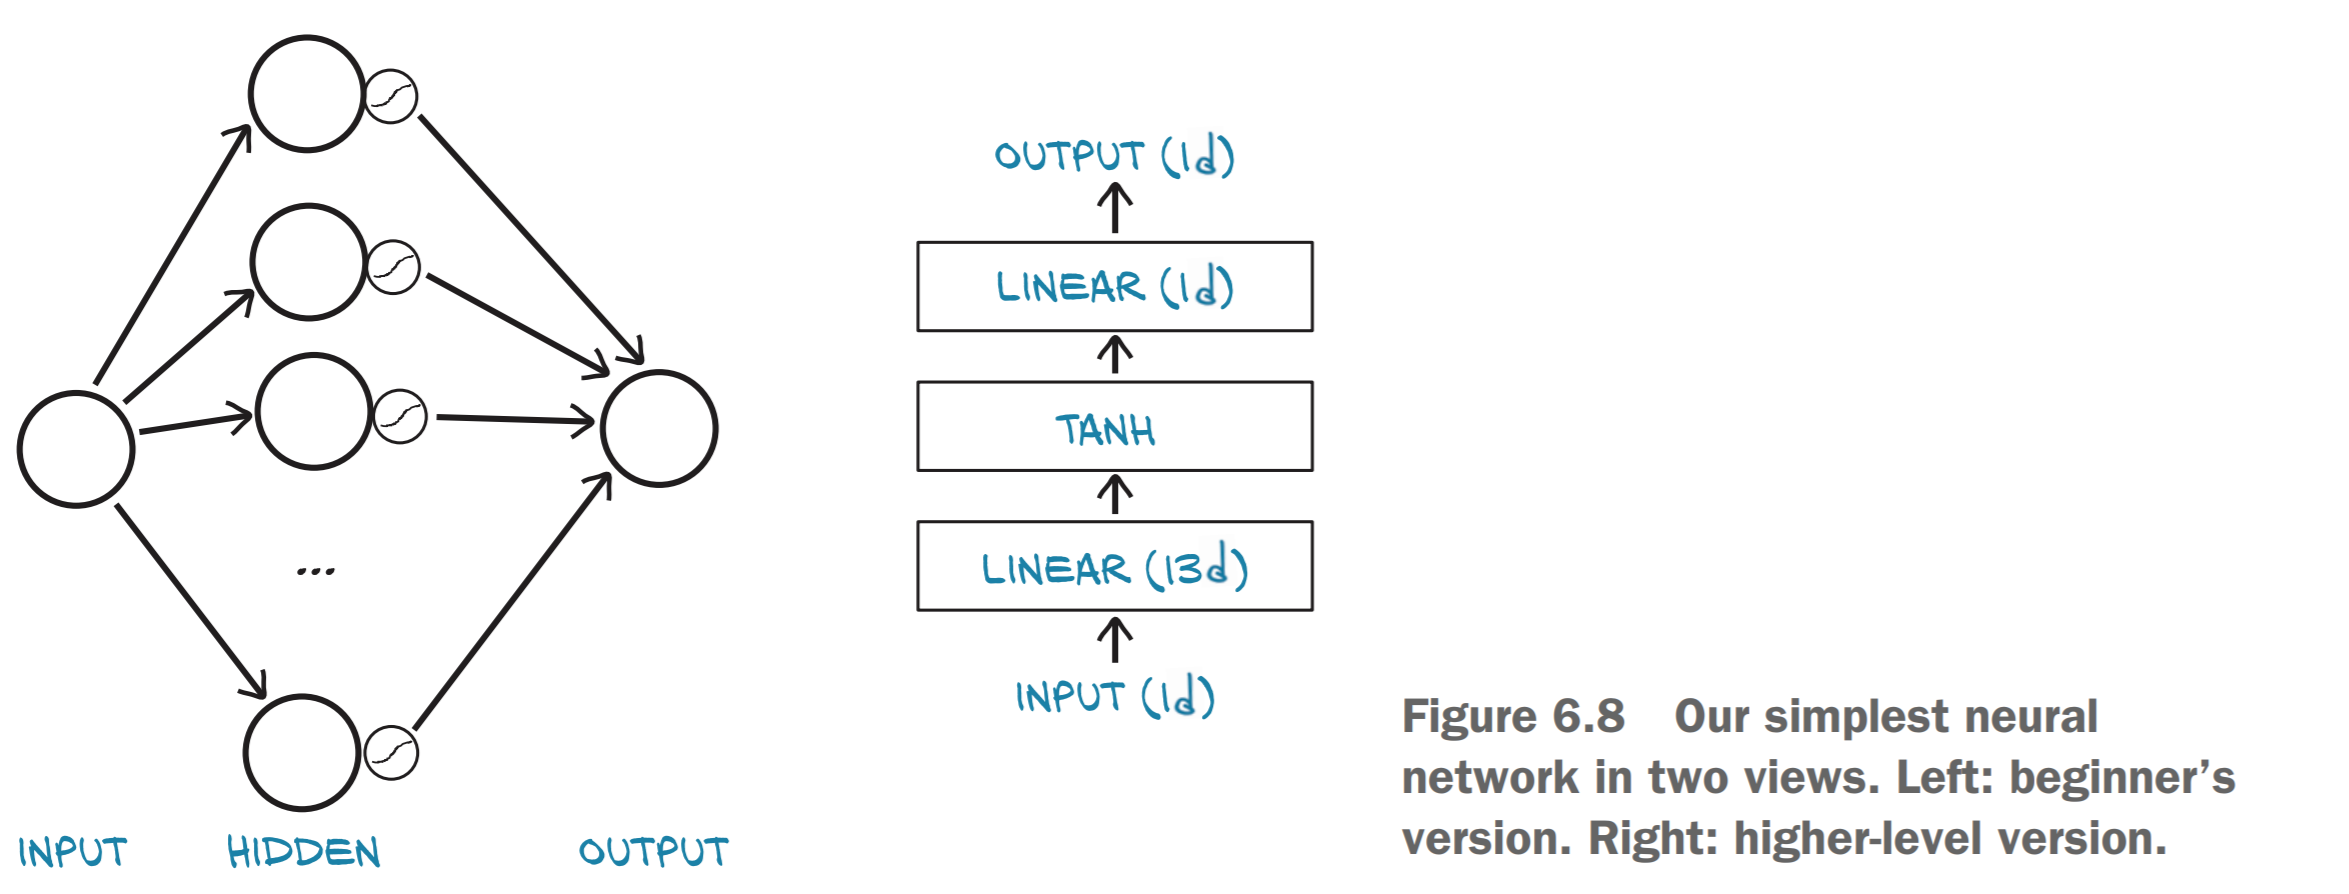

위의 1개의 hidden layer를 가지는 모델을 구성해보자.

hiddenr layer는 linear + activation function의 조합을 말한다.

In [24]:
seq_model = nn.Sequential(
nn.Linear(1, 13),
nn.Tanh(),
nn.Linear(13, 1))
seq_model

Sequential(
  (0): Linear(in_features=1, out_features=13, bias=True)
  (1): Tanh()
  (2): Linear(in_features=13, out_features=1, bias=True)
)

파라미터에 대한 정보는 다음과 같이 확인할 수 있다.

In [25]:
[param.shape for param in seq_model.parameters()]

[torch.Size([13, 1]), torch.Size([13]), torch.Size([1, 13]), torch.Size([1])]

In [26]:
for name, param in seq_model.named_parameters():
    print(name, param.shape)

0.weight torch.Size([13, 1])
0.bias torch.Size([13])
2.weight torch.Size([1, 13])
2.bias torch.Size([1])


OrderedDict를 이용하면 더 자세하게 설정을 해 줄 수 있다.


In [27]:
from collections import OrderedDict
seq_model = nn.Sequential(OrderedDict([
('hidden_linear', nn.Linear(1, 8)),
('hidden_activation', nn.Tanh()),
('output_linear', nn.Linear(8, 1))
]))
seq_model

Sequential(
  (hidden_linear): Linear(in_features=1, out_features=8, bias=True)
  (hidden_activation): Tanh()
  (output_linear): Linear(in_features=8, out_features=1, bias=True)
)

In [28]:
for name, param in seq_model.named_parameters():
    print(name, param.shape)

hidden_linear.weight torch.Size([8, 1])
hidden_linear.bias torch.Size([8])
output_linear.weight torch.Size([1, 8])
output_linear.bias torch.Size([1])


In [29]:
seq_model.output_linear.bias

Parameter containing:
tensor([-0.1579], requires_grad=True)

이제 이 모델을 학습해보자.

In [31]:
optimizer = optim.SGD(seq_model.parameters(), lr=1e-3)
training_loop(
n_epochs = 5000,
optimizer = optimizer,
model = seq_model,
loss_fn = nn.MSELoss(),
t_u_train = t_un_train,
t_u_val = t_un_val,
t_c_train = t_c_train,
t_c_val = t_c_val)
print('output', seq_model(t_un_val))
print('answer', t_c_val)
print('hidden', seq_model.hidden_linear.weight.grad)

Epoch 1, Training loss 178.0058, Validation loss 226.8954
Epoch 1000, Training loss 6.8476, Validation loss 3.8851
Epoch 2000, Training loss 5.7190, Validation loss 0.7856
Epoch 3000, Training loss 3.0966, Validation loss 2.3069
Epoch 4000, Training loss 2.2963, Validation loss 2.9401
Epoch 5000, Training loss 2.1065, Validation loss 3.1684
output tensor([[20.9199],
        [-1.4841]], grad_fn=<AddmmBackward>)
answer tensor([[21.],
        [-4.]])
hidden tensor([[ 0.0060],
        [-0.1822],
        [ 0.0105],
        [ 0.0115],
        [-0.1888],
        [-0.0383],
        [-0.1587],
        [ 0.1827]])


위의 두 모델을 비교해보자.

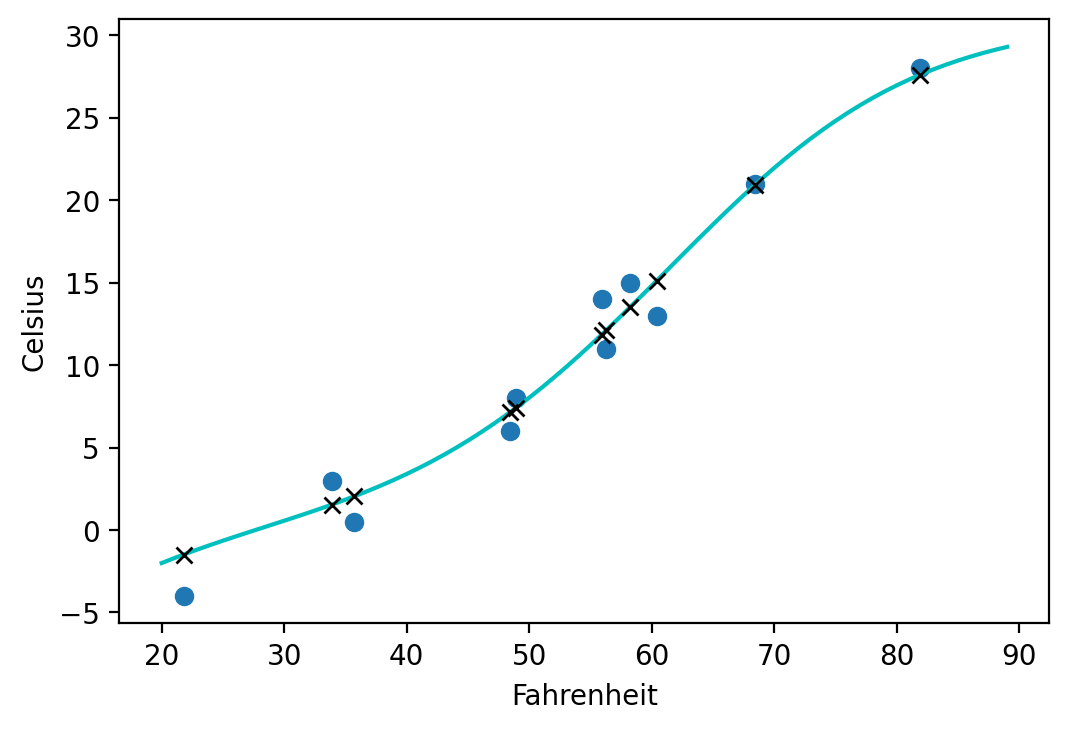

In [33]:
from matplotlib import pyplot as plt
t_range = torch.arange(20., 90.).unsqueeze(1)
fig = plt.figure(dpi=200)
plt.xlabel("Fahrenheit")
plt.ylabel("Celsius")
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.plot(t_range.numpy(), seq_model(0.1 * t_range).detach().numpy(), 'c-')
plt.plot(t_u.numpy(), seq_model(0.1 * t_u).detach().numpy(), 'kx')